# **Using XGBoost for regression purposes - predicting diamonds sale price**

**Table of contents**    
- **Using XGBoost for regression purposes - predicting diamonds sale price**    
  - Libraries    
  - Reading the data    
    - Selecting relevant columns    
    - Exploring object variables    
  - Modeling part    
    - Splitting the data    
    - Exploring the dependent variable    
    - Creating dummy variables    
    - Ploting the dependent variable after cutting the data above 99th percentile    
    - Model parameters    
    - Best paramaters    
    - Fitting the ensemble    
    - Predicting the test set    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Libraries

In [280]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

## Reading the data

In [217]:
df = pd.read_csv("diamonds.csv")

### Selecting relevant columns

In [218]:
l1 = df.iloc[:,1:6].columns.to_list()

In [219]:
l2 = df.iloc[:,12:17].columns.to_list()

In [220]:
l3 = df.iloc[:,-1:].columns.to_list()

In [221]:
l1+l2+l3

['cut',
 'color',
 'clarity',
 'carat_weight',
 'cut_quality',
 'depth_percent',
 'table_percent',
 'meas_length',
 'meas_width',
 'meas_depth',
 'total_sales_price']

In [222]:
df = df.iloc[:,df.columns.isin(l1+l2+l3)]

In [223]:
df.head()

,cut,color,clarity,carat_weight,cut_quality,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
0,Round,E,VVS2,0.09,Excellent,62.7,59.0,2.85,2.87,1.79,200
1,Round,E,VVS2,0.09,Very Good,61.9,59.0,2.84,2.89,1.78,200
2,Round,E,VVS2,0.09,Excellent,61.1,59.0,2.88,2.90,1.77,200
3,Round,E,VVS2,0.09,Excellent,62.0,59.0,2.86,2.88,1.78,200
4,Round,E,VVS2,0.09,Very Good,64.9,58.5,2.79,2.83,1.82,200


### Exploring object variables

In [224]:
for column in df.select_dtypes("object").columns.to_list():
    print(f'{column}\n\n{df[column].value_counts(normalize=True)}\n\n')

cut

Round               0.720591
Oval                0.063072
Emerald             0.050482
Pear                0.044879
Princess            0.032089
Radiant             0.025626
Heart               0.021729
Cushion Modified    0.018134
Marquise            0.013272
Asscher             0.007720
Cushion             0.002408
Name: cut, dtype: float64


color

E          0.150672
F          0.143676
D          0.140522
G          0.132834
H          0.118674
I          0.101792
J          0.076913
K          0.053481
unknown    0.041702
L          0.025867
M          0.013869
Name: color, dtype: float64


clarity

SI1     0.175815
VS2     0.173748
VS1     0.168209
SI2     0.141577
VVS2    0.131928
VVS1    0.126885
IF      0.045398
I1      0.031684
I2      0.004297
I3      0.000414
SI3     0.000046
Name: clarity, dtype: float64


cut_quality

Excellent    0.568317
unknown      0.275859
Very Good    0.155669
Good         0.000127
Fair         0.000023
Ideal        0.000005
Name: cut_quality,

#### Some categories are extremely rare and it was decided to remove them from the data set because it occured that after splitting the data, the test set and train set had unequal number of columns after creating dummy variables

In [225]:
df.shape

(219703, 11)

In [226]:
df[(df['cut_quality'].isin(["Good","Fair","Ideal"])) | (df['clarity'].isin(['SI3','I3','I2']) | (df['cut'].isin(['Asscher','Cushion'])))].index

Int64Index([    69,     77,     95,     99,    101,    110,    111,    130,
               149,    159,
            ...
            219468, 219481, 219488, 219515, 219535, 219566, 219571, 219579,
            219631, 219655],
           dtype='int64', length=3300)

In [230]:
df = df.drop(index=df[(df['cut_quality'].isin(["Good","Fair","Ideal"])) | (df['clarity'].isin(['SI3','I3','I2']) | (df['cut'].isin(['Asscher','Cushion'])))].index)

In [232]:
df = df.reset_index(drop=True)

In [234]:
len(df)

216403

## Modeling part

### Splitting the data

In [235]:
X = df.drop('total_sales_price',axis=1)
y = df['total_sales_price']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=123)
print(f'x_train: {X_train.shape}')
print(f'x_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

x_train: (151482, 10)
x_test: (64921, 10)
y_train: (151482,)
y_test: (64921,)


In [236]:
X_train

,cut,color,clarity,carat_weight,cut_quality,depth_percent,table_percent,meas_length,meas_width,meas_depth
103523,Round,M,SI1,0.71,Excellent,61.7,58.0,5.69,5.72,3.52
74096,Round,F,VVS2,0.30,Excellent,62.8,58.0,4.25,4.28,2.68
128247,Round,I,VVS2,0.56,Excellent,61.9,58.0,5.28,5.31,3.28
14203,Heart,G,SI2,0.34,unknown,51.7,60.0,4.80,5.03,2.48
108845,Oval,D,VS1,0.51,unknown,65.6,57.0,5.97,4.50,2.95
...,...,...,...,...,...,...,...,...,...,...
119906,Round,I,VS2,0.50,Excellent,62.4,57.0,5.03,5.07,3.15
192476,Oval,I,VVS2,1.50,unknown,61.6,64.0,9.74,6.16,3.80
17730,Round,I,VS2,0.30,Very Good,60.5,59.0,4.27,4.31,2.60
28030,Round,F,SI2,0.30,Excellent,62.9,56.0,4.25,4.29,2.68


### Exploring the dependent variable

#### Diamonds sale price has some extreme right-skewed values that exceed 99th percentile
#### It was decided to remove values above 99th percentile because they are too extreme

In [237]:
y_train.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99])

count    1.514820e+05
mean     6.785443e+03
std      2.576773e+04
min      2.000000e+02
10%      7.360000e+02
20%      8.900000e+02
30%      1.022000e+03
40%      1.292000e+03
50%      1.923500e+03
60%      2.902000e+03
70%      3.917000e+03
80%      6.755000e+03
90%      1.361450e+04
91%      1.469771e+04
92%      1.594600e+04
93%      1.784766e+04
94%      2.041700e+04
95%      2.358190e+04
96%      2.728100e+04
97%      3.290856e+04
98%      4.496490e+04
99%      6.278326e+04
max      1.350000e+06
Name: total_sales_price, dtype: float64

In [238]:
len(pd.DataFrame(y_train[y_train >= 63550]))

1477

In [239]:
train = pd.merge(X_train,y_train,left_index=True,right_index=True)

In [240]:
train = train[train['total_sales_price'] <= 63550]

In [241]:
test = pd.merge(X_test,y_test,left_index=True,right_index=True)

In [242]:
test = test[test['total_sales_price'] <= 63550]

In [243]:
train

,cut,color,clarity,carat_weight,cut_quality,depth_percent,table_percent,meas_length,meas_width,meas_depth,total_sales_price
103523,Round,M,SI1,0.71,Excellent,61.7,58.0,5.69,5.72,3.52,1754
74096,Round,F,VVS2,0.30,Excellent,62.8,58.0,4.25,4.28,2.68,1092
128247,Round,I,VVS2,0.56,Excellent,61.9,58.0,5.28,5.31,3.28,2816
14203,Heart,G,SI2,0.34,unknown,51.7,60.0,4.80,5.03,2.48,684
108845,Oval,D,VS1,0.51,unknown,65.6,57.0,5.97,4.50,2.95,1908
...,...,...,...,...,...,...,...,...,...,...,...
119906,Round,I,VS2,0.50,Excellent,62.4,57.0,5.03,5.07,3.15,2480
192476,Oval,I,VVS2,1.50,unknown,61.6,64.0,9.74,6.16,3.80,12608
17730,Round,I,VS2,0.30,Very Good,60.5,59.0,4.27,4.31,2.60,696
28030,Round,F,SI2,0.30,Excellent,62.9,56.0,4.25,4.29,2.68,796


In [244]:
X_train = train.drop("total_sales_price",axis=1)
y_train = train['total_sales_price']

X_test = test.drop("total_sales_price",axis=1)
y_test = test['total_sales_price']

In [245]:
print(f'x_train: {X_train.shape}')
print(f'x_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

x_train: (150005, 10)
x_test: (64281, 10)
y_train: (150005,)
y_test: (64281,)


### Creating dummy variables

In [246]:
X_train = pd.get_dummies(data=X_train,columns=X_train.select_dtypes("object").columns.to_list(),drop_first=True)
X_test = pd.get_dummies(data=X_test,columns=X_test.select_dtypes("object").columns.to_list(),drop_first=True)

In [247]:
print(f'x_train: {X_train.shape}')
print(f'x_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

x_train: (150005, 33)
x_test: (64281, 33)
y_train: (150005,)
y_test: (64281,)


### Ploting the dependent variable after cutting the data above 99th percentile

<AxesSubplot: xlabel='total_sales_price'>

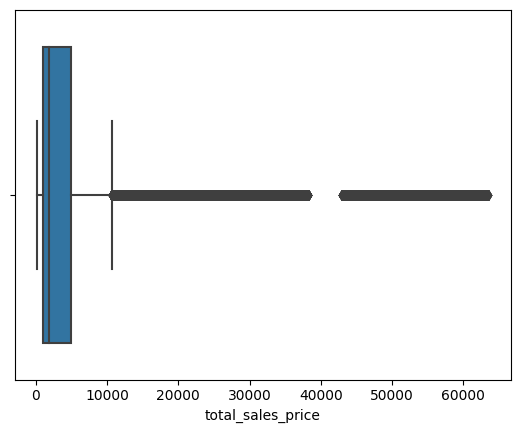

In [248]:
sns.boxplot(x=y_train)

### Model parameters

In [279]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3,4,5,6]
}

In [281]:
xg_reg = XGBRegressor()

In [297]:
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [283]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [284]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

### Best paramaters

In [285]:
best_params

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}

In [286]:
best_score

-4509408.869445642

In [298]:
xg_reg = XGBRegressor(**best_params,random_state=123)

### Fitting the ensemble

In [299]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

### Predicting the test set

In [301]:
xg_reg.predict(X_test)

array([  987.47534,  1132.9198 ,  2852.219  , ..., 13144.277  ,
         634.3306 ,  2212.634  ], dtype=float32)

In [302]:
mean_absolute_error(y_true = y_test, y_pred = xg_reg.predict(X_test))

668.8212831166973

In [303]:
mean_absolute_percentage_error(y_true = y_test, y_pred = xg_reg.predict(X_test))

0.13292344035696627

In [304]:
x_ax = range(len(y_test))

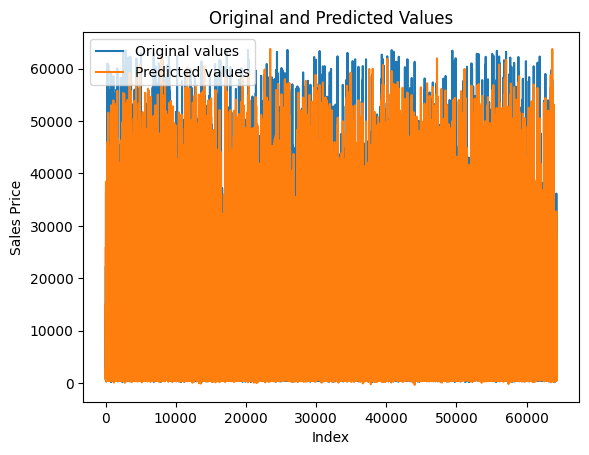

In [305]:
plt.plot(x_ax,y_test, label="Original values")
plt.plot(x_ax,xg_reg.predict(X_test), label="Predicted values")
plt.title("Original and Predicted Values")
plt.xlabel("Index")
plt.ylabel("Sales Price")
plt.legend()
plt.show()